Macieszczak's variational algorithm

Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

import numpy as np

# import scipy
import pandas as pd
from tqdm.notebook import tqdm

# from time import sleep

from fisher_information import *
from truncated_pure_states import *


# imports for plotting
import matplotlib.pyplot as plt

# LaTeX fonts
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
plt.rcParams.update({"font.size": 18})

Autosaving every 60 seconds


Plotter for imshow

In [2]:
def plot_imshow(X, title="", no_show=False):
    fig, axs = plt.subplots(
        1,
        3,
        figsize=(12, 3),
        gridspec_kw={
            "wspace": 0.4,
            # "hspace": 0.05,
        },
    )
    axs = list(reversed(axs))

    im = axs[0].imshow(X.real)
    fig.colorbar(im, ax=axs[0], label="real component")
    axs[0].set(xlabel="n", ylabel="m")

    data = X.diagonal().real
    xaxis = np.arange(len(data))
    # TODO: handle zero values
    datas = [
        [xaxis[data != 0], np.abs(data[data != 0])],
        [xaxis[data > 0], np.abs(data[data > 0])],
        [xaxis[data < 0], np.abs(data[data < 0])],
    ]
    axs[1].semilogy(datas[0][0], datas[0][1], "-", color="grey")
    axs[1].semilogy(datas[1][0], datas[1][1], ".", color="b", label=r"$+$")
    axs[1].semilogy(datas[2][0], datas[2][1], ".", color="r", label=r"$-$")
    axs[1].legend(
        title="sign",
        handlelength=1,
        labelspacing=0,
        frameon=False,
        handletextpad=0.3,
        fontsize=18,
    )
    axs[1].set(xlabel="n", ylabel="magnitude")
    axs[1].grid("both", "both", color="gainsboro")

    axs[2].plot(xaxis, data, ".-", color="k")
    axs[2].set(xlabel="n", ylabel="signed value")
    axs[2].grid("both", "both", color="gainsboro")

    fig.suptitle(title, y=1.05)

    if not no_show:
        plt.show(fig)
    return fig, axs

Settings

In [3]:
# Fock beats SMSV
settings = dict(
    σ=0.01,
    δσ=1e-5,
    η=0.1,
    nbar0=1.0,
    # full displacement, else the eigenvalues cut out
    encoding_truncation=None,
    which_FI="QFI",
)

# renormalise=True, changed later
construct_total_channel(settings)

Optimal Fock state

In [13]:
FI_total_channel_pure_state(pure_state_ket_parts("Fock", dict(n=1)), settings)

3.6012573282005405

In [ ]:
data = {}
for n in range(Nmax + 1):
    data[n] = FI_total_channel_pure_state(
        pure_state_ket_parts("Fock", dict(n=n)), settings
    )
data = pd.DataFrame(data.items(), columns=["n", "QFI"])

display(data.sort_values("QFI", ascending=False).head())
display(data.sort_values("QFI", ascending=False).tail())

In [ ]:
display(data.sort_values("QFI", ascending=False).head())
display(data.sort_values("QFI", ascending=False).tail())

#### Vacuum

In [ ]:
# vacuum
ρ_vac = ρ_for_pure_state("Fock", dict(n=0))
plot_wigner(ρ_vac)

In [ ]:
ρ0 = ρ_vac

# derivative at midpoint like simon

ρ1 = settings["channel"](ρ0, settings["σ"])
ρ2 = settings["channel"](ρ0, settings["σ"] + settings["δσ"])

ρ = 0.5 * (ρ1 + ρ2)
ρ /= np.trace(ρ)

dρ = ρ2 - ρ1
deriv = dρ / settings["δσ"]

SLD

In [ ]:
# The normalized (unit “length”) eigenvectors, such that the column eigenvectors[:,i] is the eigenvector corresponding to the eigenvalue eigenvalues[i].
evals, evecs = np.linalg.eig(ρ)

SLD = np.zeros_like(ρ)

for j in range(Nmax + 1):
    psi_j = evecs[:, j]
    λ_j = evals[j]

    for k in range(Nmax + 1):
        psi_k = evecs[:, k]
        λ_k = evals[k]

        # drop singular values
        if λ_k + λ_j == 0:
            continue

        # drop negative evals like QuTiP, FQ_element[j, k] remains zero
        if λ_j.real < 0 or λ_k.real < 0:
            continue

        tolerance = 1e-15
        if abs(λ_j.imag) > tolerance or abs(λ_k.imag) > tolerance:
            print(λ_j, λ_k)
            raise ValueError("Eigenvalues are complex.")
        else:
            # TODO: check that this is not editing the array in-place
            λ_j = λ_j.real
            λ_k = λ_k.real

        # Paris09, Eq 12
        SLD += (
            2
            * (np.conj(psi_k) @ deriv @ psi_j)
            / (λ_k + λ_j)
            * np.outer(psi_k, np.conj(psi_j))
        )

Recovers the QFI

In [ ]:
# check that QFI recovered, yep!
tol = 1e-15
QFI = qfi(ρ1, ρ2, settings["δσ"])
QFI_here = np.trace(ρ @ np.linalg.matrix_power(SLD, 2))
print(
    f"QFI recovered: {abs(QFI - QFI_here) < tol}, QFI = {QFI}, tr(rho L^2) = {QFI_here}, abs diff = {abs(QFI - QFI_here)}, tol = {tol}."
)

Plotting the SLD

In [ ]:
# TODO: check if there's a bug here that the encoding truncates?

# SLD before
print(np.argmin(np.abs(SLD).diagonal()))
print(np.argmax(np.abs(SLD).diagonal()))
plt.imshow(np.abs(SLD))
plt.show()

In [ ]:
diag = SLD.diagonal()
data = np.transpose(np.array([[*range(Nmax + 1)], [*diag]]))

plt.semilogy(data[:, 0], np.abs(data[:, 1]), ".-")
plt.semilogy(
    data[data[:, 1] < 0][:, 0], np.abs(data[data[:, 1] < 0][:, 1]), ".", color="r"
)
plt.show()

2nd phase

In [ ]:
# our channel is self-dual
def G_old(X):
    σ = settings["σ"]
    Ux = lambda X0, α: displace(X0, α, settings["encoding_truncation"])
    return -1 * random_channel(
        np.linalg.matrix_power(X, 2), σ, Ux
    ) + 2 * random_channel(X, σ, Ux, use_pdot=True)


G_SLD = G_old(SLD)
evals, evecs = np.linalg.eig(G_SLD)
# evec will abs largest eval is the next pure state
# # new initial state
# The normalized (unit “length”) eigenvectors, such that the column eigenvectors[:,i] is the eigenvector corresponding to the eigenvalue eigenvalues[i].
ket_1iteration = evecs[:, np.argmax(np.abs(evals))]
ρ0_1iteration = ρ_from_ket(ket_1iteration)

In [ ]:
Fock_max = np.argmax(ket_1iteration)
print(Fock_max, ket_1iteration[Fock_max])

Plotting preimage of SLD

In [ ]:
# SLD after
print(np.argmin(np.abs(G_SLD).diagonal()))
print(np.argmax(np.abs(G_SLD).diagonal()))
plt.imshow(np.abs(G_SLD))
plt.show()

New initial state looks like $\ket{26}$

In [ ]:
plot_wigner(ρ0_1iteration)

In [ ]:
FI_total_channel_pure_state(pure_state_ket_parts("Fock", dict(n=Fock_max)), settings)

#### Functionalise iteration

SLD definition

In [2]:
# TODO: pull out into a separate file.py with settings as argument
def sld(ρ0, debug=False, chop=False):
    # derivative at midpoint like simon
    ρ1 = settings["channel"](ρ0, settings["σ"])
    ρ2 = settings["channel"](ρ0, settings["σ"] + settings["δσ"])

    ρ = 0.5 * (ρ1 + ρ2)
    ρ /= np.trace(ρ)

    dρ = ρ2 - ρ1
    deriv = dρ / settings["δσ"]

    # The normalized (unit “length”) eigenvectors, such that the column eigenvectors[:,i] is the eigenvector corresponding to the eigenvalue eigenvalues[i].
    evals, evecs = np.linalg.eig(ρ)

    SLD = np.zeros_like(ρ)
    if debug:
        SLD_components = np.zeros_like(ρ)

    for j in range(Nmax + 1):
        ψ_j = evecs[:, j]
        λ_j = evals[j]

        for k in range(Nmax + 1):
            ψ_k = evecs[:, k]
            λ_k = evals[k]

            # drop singular values
            if λ_k + λ_j == 0:
                continue

            tol = 1e-15
            if chop:
                # drop numerically singular values
                if abs(λ_k.real + λ_j.real) < tol:
                    continue

            # drop negative evals like QuTiP, FQ_element[j, k] remains zero
            if λ_j.real < 0 or λ_k.real < 0:
                continue

            if abs(λ_j.imag) > tol or abs(λ_k.imag) > tol:
                print(λ_j, λ_k)
                raise ValueError("Eigenvalues are complex.")
            else:
                # TODO: check that this is not editing the array in-place
                λ_j = λ_j.real
                λ_k = λ_k.real

            # Paris09, Eq 12
            component = 2 * (np.conj(ψ_k) @ deriv @ ψ_j) / (λ_k + λ_j)
            SLD += component * np.outer(ψ_k, np.conj(ψ_j))
            if debug:
                SLD_components[j, k] = component

    if not debug:
        return SLD
    else:
        return dict(
            sld=SLD,
            sld_components=SLD_components,
            deriv=deriv,
            ρ=ρ,
            evals=evals,
            evecs=evecs,
        )

G (old)

In [ ]:
# def G(X):
def G_old(X):
    # our channel is self-dual because it is a random unitary with an even probability distribution
    Xsqr = np.linalg.matrix_power(X, 2)
    σ = settings["σ"]
    U = lambda X0, α: displace(X0, α, settings["encoding_truncation"])
    return -1 * random_channel(Xsqr, σ, U) + 2 * random_channel(X, σ, U, use_pdot=True)

2nd step

In [6]:
def next_state_from_SLD(SLD, return_ket=False):
    # G_SLD = G_old(SLD)
    G_SLD = G(SLD)
    evals, evecs = np.linalg.eig(G_SLD)
    # evec with largest magnitude eval is the next pure state, remember to index correctly
    # The normalized (unit "length") eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].
    ket = evecs[:, np.argmax(np.abs(evals))]
    if return_ket:
        return ket
    else:
        ρ_next = ρ_from_ket(ket)
        return ρ_next


def next_state_from_given_state(ket, **kwargs):
    # working with ket since the states are pure
    ρ = ρ_from_ket(ket)
    ket_next = next_state_from_SLD(sld(ρ, **kwargs), return_ket=True)
    return ket_next

Iteration

In [17]:
def var_algorithm(ket, num_iter=2, plot=True, **kwargs):
    # TODO: use functools to apply the function a bunch of times
    kets = [
        ket,
    ]
    # TODO: have instead one loop that computes and prints/plots
    for _ in range(num_iter):
        kets.append(next_state_from_given_state(kets[-1], **kwargs))

    qfis = [FI_total_channel_pure_state(complex_to_real(ket), settings) for ket in kets]

    if plot:
        for i, ket in enumerate(kets):
            # TODO: also plot the final state
            fig, _ = plot_wigner(ket)
            title = f"Iteration {i}: QFI = {qfis[i]:.3f}."
            fig.suptitle(title, y=1.05)
            plt.show(fig)

            title = f"Iteration {i}: " + r"SLD, $L$."
            fig, _ = plot_imshow(sld(ρ_from_ket(ket), **kwargs), title)
            plt.show(fig)

    data = {}
    for i in range(num_iter + 1):
        data[i] = dict(qfi=qfis[i], ket=kets[i])
    return data

#### Different starts

Check on vacuum against above

In [ ]:
ket0 = pure_state_ket_parts("Fock", dict(n=0), return_ket=True)
ket1 = next_state_from_given_state(ket0)

In [ ]:
print(
    f"Recovers the previous next state |26>: {np.sum(np.abs(ρ0_1iteration - ρ_from_ket(ket1))**2) < tol}"
)

Next iteration

In [ ]:
ket2 = next_state_from_given_state(ket1)

In [ ]:
plot_wigner(ket2)

In [ ]:
FI_total_channel_pure_state(complex_to_real(ket2), settings)

$\ket{1}$

In [ ]:
data = var_algorithm(pure_state_ket_parts("Fock", dict(n=1), return_ket=True))

$\ket{8}$ (the optimal Fock)

In [ ]:
data = var_algorithm(
    pure_state_ket_parts("Fock", dict(n=8), return_ket=True), num_iter=4
)

SMSV

In [ ]:
ket0 = pure_state_ket_parts("SMSV", dict(r=1.1, θ=0), return_ket=True)
data = var_algorithm(ket0, num_iter=5)

**The Killer**

In [ ]:
data[4]

In [ ]:
FI_total_channel_pure_state(complex_to_real(data[4]["ket"]), settings)

In [ ]:
# TODO: test it with a higher truncation index such that the Fock states escape
# TODO: make Nmax variable
def f():
    Nmax = 50
    print(Nhat)


f()

In [ ]:
# blunter way: save and restart with different Nmax
file = "./data/optimisation/variational/killer.npy"
ket_killer = data[4]["ket"]
np.save(file, ket_killer)

SMSV at an angle

In [ ]:
data = var_algorithm(
    pure_state_ket_parts("SMSV", dict(r=1.1, θ=np.pi / 4), return_ket=True), num_iter=4
)

Coherent state

In [ ]:
data = var_algorithm(
    pure_state_ket_parts("coherent", dict(α=0.7 + 0.2j), return_ket=True),
    num_iter=4,
)

Cat state

In [ ]:
data = var_algorithm(
    pure_state_ket_parts("cat", dict(α=2 + 0.2j, pm=1), return_ket=True),
    num_iter=3,
)

#### Killer (reloaded)

- QFI=9.49006990237156, Nmax=101, 1m 16s
- QFI=9.490069902871298, Nmax=51, 5s
- QFI=9.36537726896114, Nmax=31

Fock maximum value
- QFI=7.743131, $\ket8$, Nmax=31

In [34]:
# load previously saved killer state
file = "./data/optimisation/variational/killer.npy"
ket_killer = np.load(file)
# extend it
ket_killer_ext = np.array([*ket_killer, *np.zeros(Nmax + 1 - len(ket_killer))])

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

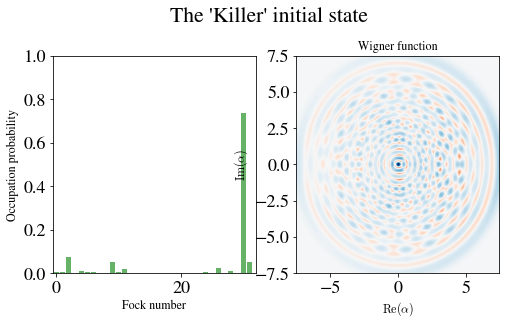

In [38]:
ρ0 = ρ_from_ket(ket_killer_ext)
plot_wigner(ρ0, title="The 'Killer' initial state")

In [ ]:
# Not a normalisation issue
norm(complex_to_real(ket_killer_ext))

In [ ]:
# Fock beats SMSV
settings = dict(
    σ=0.01,
    δσ=1e-5,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

# TODO: explain whether this is real for the extended killer (the value has changed by order 0.1 but remains above 7.74 for the best Fock)
FI_total_channel_pure_state(complex_to_real(ket_killer_ext), settings)

Plotting final states

In [ ]:
ρ0 = ρ_from_ket(ket_killer_ext)
ρ1 = settings["channel"](ρ0, settings["σ"])
ρ2 = settings["channel"](ρ0, settings["σ"] + settings["δσ"])

# TODO: calculate and plot the derivative

In [ ]:
plot_wigner(ρ0, title="Initial state")
plot_wigner(ρ1, title="Final state")
# plot_wigner(ρ2, title="Final state + delta")

In [ ]:
plot_wigner(dephase(ρ0), title="Dephased initial state")
plot_wigner(dephase(ρ1), title="Dephased final state")

Chopping up the killer

In [ ]:
# cut = 12
cut = 20

killer_LHS = np.zeros_like(ket_killer_ext)
killer_RHS = np.zeros_like(ket_killer_ext)
killer_LHS[:cut] = ket_killer_ext[:cut]
killer_RHS[cut:] = ket_killer_ext[cut:]
killer_LHS = normalise(killer_LHS, is_ket=True)
killer_RHS = normalise(killer_RHS, is_ket=True)
# TODO: normalise

In [ ]:
plt.plot(killer_LHS, ".-", label="LHS")
plt.plot(killer_RHS, ".-", label="RHS")
plt.plot(ket_killer_ext, ".-", label="total")
plt.legend()

In [ ]:
# Fock beats SMSV
settings = dict(
    σ=0.01,
    δσ=1e-5,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

print(f"LHS QFI: {FI_total_channel_pure_state(complex_to_real(killer_LHS), settings)}")
print(f"RHS QFI: {FI_total_channel_pure_state(complex_to_real(killer_RHS), settings)}")

In [ ]:
plot_wigner(killer_LHS, title="Initial state: LHS")
plot_wigner(
    settings["channel"](ρ_from_ket(killer_LHS), settings["σ"]),
    title="Final state from LHS",
)

plot_wigner(killer_RHS, title="Initial state: RHS")
plot_wigner(
    settings["channel"](ρ_from_ket(killer_RHS), settings["σ"]),
    title="Final state from RHS",
)

In [ ]:
plot_wigner(
    settings["channel"](ρ_from_ket(killer_LHS), settings["σ"]),
    title="Final state from LHS",
)
plot_wigner(
    settings["channel"](ρ_from_ket(killer_RHS), settings["σ"]),
    title="Final state from RHS",
)

Sensitivity of FI for killer to parameters

In [ ]:
settings = dict(
    # σ=0.01,
    σ=0.001,
    δσ=1e-5,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

FI_total_channel_pure_state(complex_to_real(ket_killer_ext), settings)

In [ ]:
settings = dict(
    # σ=0.01,
    σ=0.001,
    # δσ=1e-5,
    δσ=1e-6,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

FI_total_channel_pure_state(complex_to_real(ket_killer_ext), settings)

In [ ]:
# at some point the stepsize becomes a problem for all calculations, so this might not tell us anythgin
settings = dict(
    # σ=0.01,
    σ=0.001,
    # δσ=1e-5,
    δσ=1e-7,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

FI_total_channel_pure_state(complex_to_real(ket_killer_ext), settings)

In [ ]:
settings = dict(
    σ=0.01,
    # δσ=1e-5,
    δσ=1e-7,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

FI_total_channel_pure_state(complex_to_real(ket_killer_ext), settings)

In [ ]:
# large change, but large step, so that's fine
settings = dict(
    σ=0.01,
    # δσ=1e-5,
    δσ=1e-3,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

FI_total_channel_pure_state(complex_to_real(ket_killer_ext), settings)

In [ ]:
# below the numerical error, still works?!
settings = dict(
    σ=0.01,
    # δσ=1e-5,
    δσ=1e-9,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

FI_total_channel_pure_state(complex_to_real(ket_killer_ext), settings)

Different loss

In [ ]:
# unsurprising that QFI drops with higher loss, not really what we were looking for (unless we can compute Fock again with this new loss)
settings = dict(
    # σ=0.01,
    σ=0.001,
    δσ=1e-5,
    # η=0.1,
    η=0.2,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

FI_total_channel_pure_state(complex_to_real(ket_killer_ext), settings)

#### Channel as a linear superoperator (LSO)

Λ definition

In [ ]:
# F is fortran ordering, i.e. by column, to achieve column-stacking
vectorise = lambda M: M.flatten(order="F")
unvectorise = lambda v: v.reshape((Nmax + 1, Nmax + 1), order="F")

# TODO: make construct adapt if given sigma
Λ = lambda ρ: construct_total_channel(settings, renormalise=False, in_place=False)(
    ρ, settings["σ"]
)

LSO long sum

In [ ]:
# takes 1 min

Λ_LSO = np.zeros(((Nmax + 1) ** 2, (Nmax + 1) ** 2))

for k in tqdm(range(Nmax + 1), desc="k loop"):
    for j in range(Nmax + 1):
        # i = j + k * (Nmax + 1)
        # k, j = divmod(i, Nmax + 1)
        Λ_LSO[:, j + k * (Nmax + 1)] = vectorise(Λ(basis_element(j, k)))

file = "./data/optimisation/variational/LSO.npy"
np.save(file, Λ_LSO)

apply_Λ_LSO = lambda ρ: unvectorise(Λ_LSO @ vectorise(ρ))

In [ ]:
# TODO: parallelise the above lengthy sum

##### Check that recovers known states

Checking Hermitiancy

In [ ]:
input = basis_element(9, 4)
x = Λ(input)
y = Λ(dag(input))
tol = 1e-15
print(np.all(np.abs(x - dag(y)) < tol))

Vacuum

In [ ]:
ρ0 = ρ_for_pure_state("vacuum")
np.all(apply_Λ_LSO(ρ0) == Λ(ρ0))

Fock

In [ ]:
ρ0 = ρ_for_pure_state("Fock", dict(n=1))
tol = 1e-15
print(np.all(np.abs(apply_Λ_LSO(ρ0) - Λ(ρ0)) < tol))

Coherent

In [ ]:
ρ0 = ρ_for_pure_state("coherent", dict(α=0.5))
tol = 1e-15
resultLSO = apply_Λ_LSO(ρ0)
resultNormal = Λ(ρ0)
error = np.abs(resultLSO - resultNormal)
print(np.all(error < tol))
print(np.max(error))

Cat

In [ ]:
ρ0 = ρ_for_pure_state("cat", dict(α=0.5, pm=-1))
tol = 1e-15
resultLSO = apply_Λ_LSO(ρ0)
resultNormal = Λ(ρ0)
error = np.abs(resultLSO - resultNormal)
print(np.all(error < tol))
print(np.max(error))

SMSV

In [ ]:
ρ0 = ρ_for_pure_state("SMSV", dict(r=1.2, θ=0))
tol = 1e-15
resultLSO = apply_Λ_LSO(ρ0)
resultNormal = Λ(ρ0)
error = np.abs(resultLSO - resultNormal)
print(np.all(error < tol))
print(np.max(error))

##### Dual channel

In [ ]:
Λ_dual_LSO = dag(Λ_LSO)
Λ_dual = lambda X: unvectorise(Λ_dual_LSO @ vectorise(X))

Λdot definition

In [ ]:
Λdot = lambda ρ: construct_total_channel(
    settings, use_pdot=True, renormalise=False, in_place=False
)(ρ, settings["σ"])

In [ ]:
# takes 1 min, again

Λdot_LSO = np.zeros(((Nmax + 1) ** 2, (Nmax + 1) ** 2))

for k in tqdm(range(Nmax + 1), desc="k loop"):
    for j in range(Nmax + 1):
        Λdot_LSO[:, j + k * (Nmax + 1)] = vectorise(Λdot(basis_element(j, k)))

file = "./data/optimisation/variational/LSO_dot.npy"
np.save(file, Λdot_LSO)

# apply_Λdot_LSO = lambda ρ: unvectorise(Λdot_LSO @ vectorise(ρ))

In [ ]:
Λdot_dual_LSO = dag(Λdot_LSO)
Λdot_dual = lambda X: unvectorise(Λdot_dual_LSO @ vectorise(X))

Re-implement algorithm

In [ ]:
# reset channel in settings
construct_total_channel(settings)

G

In [ ]:
# def G(X):
def G_LSO(X):
    Xsqr = np.linalg.matrix_power(X, 2)
    return -1 * Λ_dual(Xsqr) + 2 * Λdot_dual(X)

#### Debug

Vacuum

In [ ]:
data = var_algorithm(pure_state_ket_parts("vacuum", return_ket=True), num_iter=5)

In [ ]:
data[1]

In [ ]:
# TODO: why is this QFI so low? Is this the NN worst case?
data[2]

Stepping through

In [ ]:
construct_total_channel(settings)
ket0 = pure_state_ket_parts("vacuum", return_ket=True)
ρ = ρ_from_ket(ket0)
SLD = sld(ρ)
G_SLD = G(SLD)
ket1 = next_state_from_SLD(SLD, return_ket=True)

In [ ]:
plot_imshow(SLD, r"SLD, $L$")
plot_imshow(Nhat, r"$\hat{n}$")
plot_imshow(G_SLD, r"$G(L)$")
plot_imshow(G(Nhat), r"$G(\hat{n})$")
plot_imshow(Λ_dual(Nhat @ Nhat), r"$\Lambda^\dag(\hat{n}^2)$")
plot_imshow(Λdot_dual(Nhat), r"$\dot{\Lambda}^\dag(\hat{n})$")

In [ ]:
evals, evecs = np.linalg.eig(G(Nhat))
evecs[:, np.argmax(np.abs(evals))]

##### Debug SLD

In [5]:
construct_total_channel(settings)
ket0 = pure_state_ket_parts("vacuum", return_ket=True)
ρ = ρ_from_ket(ket0)
sld_dict = sld(ρ, debug=True)
SLD = sld_dict["sld"]

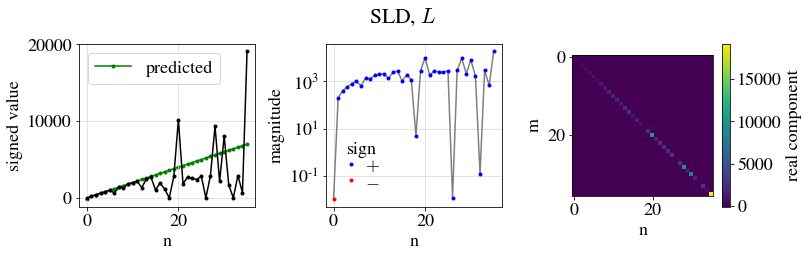

In [6]:
fig, axs = plot_imshow(SLD, r"SLD, $L$", no_show=True)
ns = list(range(Nmax + 1))
Ls = [2 * n / settings["σ"] if n != 0 else -2 / settings["σ"] for n in ns]

axs[2].plot(ns, Ls, ".-", color="g", zorder=0, label="predicted")
axs[2].legend()
plt.show(fig)

In [ ]:
sorted(sld_dict["evals"], reverse=True)

In [ ]:
plot_imshow(sld_dict["deriv"])

10 -> components

In [ ]:
# sld_dict["sld_components"].shape
# TODO: use unravel_index to get the index tuple from the flat array like with divmod above
np.argmax(sld_dict["sld_components"])

In [ ]:
np.argmax(sld_dict["sld_components"].diagonal())

In [ ]:
sld_dict["sld_components"][10, 10]

In [ ]:
numer = 2 * (np.conj(sld_dict["evecs"][10]) @ sld_dict["deriv"] @ sld_dict["evecs"][10])
denom = 2 * sld_dict["evals"][10]
numer / denom
# TODO: why doesn't this equal 3000?

In [ ]:
numer / 2

In [ ]:
(np.conj(sld_dict["evecs"][10]) @ sld_dict["deriv"] @ sld_dict["evecs"][10])

In [ ]:
# Why isn't this the same?
sld_dict["deriv"][10, 10]

In [ ]:
x = np.zeros_like(sld_dict["evecs"][10])
x[10] = 1
sld_dict["deriv"][10, 10] == (np.conj(x) @ sld_dict["deriv"] @ x)

In [ ]:
for cut in range(Nmax + 1):
    numer = (
        np.conj(sld_dict["evecs"][10])[cut:]
        @ sld_dict["deriv"][cut:, cut:]
        @ sld_dict["evecs"][10][cut:]
    )
    print(f"cut at {cut}, numer = {numer:.3g}")
# -> large components at 2, 4, small at 10

In [ ]:
x - sld_dict["evecs"][10]

In [ ]:
np.conj(sld_dict["evecs"][10])

In [ ]:
sld_dict["evals"][10]

In [ ]:
# remember that j,k are the indices of the evecs here
#            component = 2 * (np.conj(ψ_k) @ deriv @ ψ_j) / (λ_k + λ_j)
#            SLD += component * np.outer(ψ_k, np.conj(ψ_j))
#            SLD_components[j, k] = component
# probably out of order : TODO: reorder eigensystem to match the diagonal in sld()
plot_imshow(sld_dict["sld_components"])

In [ ]:
# sorting the components does not match the prediction, or the SLD (because the evecs are not diagonals)
plt.plot(sorted(sld_dict["sld_components"].diagonal()), ".-")
plt.plot(ns, Ls, ".-", zorder=0, color="g")

##### Chopped SLD

In [ ]:
construct_total_channel(settings)
ket0 = pure_state_ket_parts("vacuum", return_ket=True)

SLD (chopped) for Ket 0 compared to prediction

In [ ]:
ρ = ρ_from_ket(ket0)
sld_dict = sld(ρ, return_dict=True, chop=True)
SLD = sld_dict["sld"]
G_SLD = G(SLD)
ket1 = next_state_from_SLD(SLD, return_ket=True)

fig, axs = plot_imshow(SLD, r"SLD, $L$", no_show=True)
ns = list(range(Nmax + 1))
Ls = [2 * n / settings["σ"] if n != 0 else -2 / settings["σ"] for n in ns]

axs[2].plot(ns, Ls, ".-", color="g", zorder=0, label="predicted")
axs[2].legend()
plt.show(fig)

Iterated

In [ ]:
data = var_algorithm(ket0, num_iter=10, chop=True)

In [ ]:
{k: v["qfi"] for (k, v) in data.items()}

##### Duals and trace

In [11]:
def print_error(x1, x2):
    dp = 2
    error = np.abs(x1 - x2)
    tol = 1e-15
    print(
        f"Equal: {error < tol}. Error = {error:.{dp}g}. Value 1 = {x1:.{dp}g}. Value 2 = {x2:.{dp}g}."
    )

Dual

In [ ]:
# ρ = ρ_for_pure_state("vacuum")
ρ = ρ_for_pure_state("coherent", dict(α=0.5))

X = Nhat
ev = np.trace(Λ(ρ) @ X)
ev_dualed = np.trace(ρ @ Λ_dual(X))
print_error(ev, ev_dualed)

X = (a + ad) / math.sqrt(2)
ev = np.trace(Λ(ρ) @ X)
ev_dualed = np.trace(ρ @ Λ_dual(X))
print_error(ev, ev_dualed)

Dual of the derivative

In [ ]:
# ρ = ρ_for_pure_state("vacuum")
ρ = ρ_for_pure_state("coherent", dict(α=0.5))

X = Nhat
dotev = np.trace(Λdot(ρ) @ X)
dotev_dualed = np.trace(ρ @ Λdot_dual(X))
print_error(dotev, dotev_dualed)

X = (a + ad) / math.sqrt(2)
dotev = np.trace(Λdot(ρ) @ X)
dotev_dualed = np.trace(ρ @ Λdot_dual(X))
print_error(dotev, dotev_dualed)

Numerical derivative of an EV

In [ ]:
ρ0 = ρ_for_pure_state("coherent", dict(α=0.5))
X = Nhat

# ev1 = np.trace(Λ(ρ0) @ X)
dotev1 = np.trace(Λdot(ρ0) @ X)
# print(ev1, dotev1)

construct_total_channel(settings)
ρ1 = settings["channel"](ρ0, settings["σ"])
ρ2 = settings["channel"](ρ0, settings["σ"] + settings["δσ"])

# ρ = 0.5 * (ρ1 + ρ2)
# ρ /= np.trace(ρ)

dρ = ρ2 - ρ1
deriv = dρ / settings["δσ"]
deriv_ev1 = np.trace(deriv @ X)
# print(deriv_ev1)
print_error(deriv_ev1, dotev1)

Unitality of loss channel

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

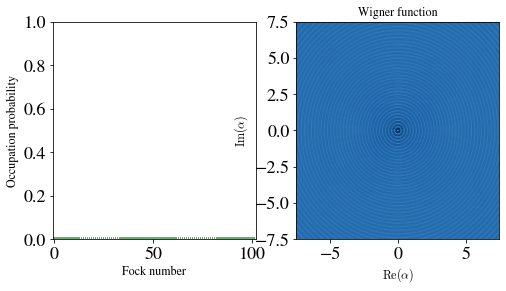

In [2]:
ρ = np.diag(np.full(Nmax + 1, 1 / (Nmax + 1)))
plot_wigner(ρ)

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

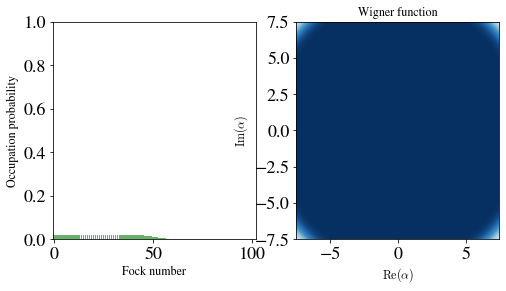

In [3]:
η = 0.5
ρ1 = loss_binomial(ρ, η=η)
plot_wigner(ρ1)

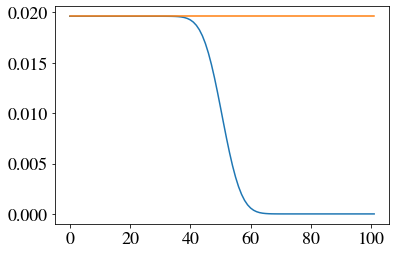

In [9]:
plt.plot(ρ1.diagonal())
plt.plot(np.full_like(ρ1.diagonal(), 1 / (1 - η) * 1 / (Nmax + 1)))

##### Kraus dual

Unitality

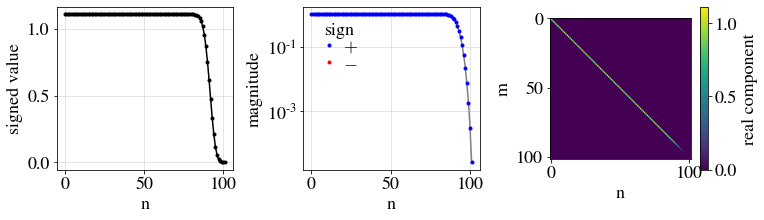

(<Figure size 864x216 with 4 Axes>,
 [<AxesSubplot:xlabel='n', ylabel='m'>,
  <AxesSubplot:xlabel='n', ylabel='magnitude'>,
  <AxesSubplot:xlabel='n', ylabel='signed value'>])

In [5]:
# loss channel is super-unital, plus some truncation effects
plot_imshow(loss_kraus(np.identity(Nmax + 1), η=0.1))

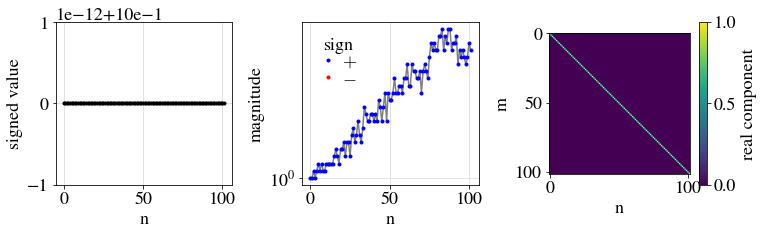

(<Figure size 864x216 with 4 Axes>,
 [<AxesSubplot:xlabel='n', ylabel='m'>,
  <AxesSubplot:xlabel='n', ylabel='magnitude'>,
  <AxesSubplot:xlabel='n', ylabel='signed value'>])

In [6]:
# dual map is unital for any channel (even though dual map is not itself a channel)
plot_imshow(loss_dual_kraus(np.identity(Nmax + 1), η=0.1))

Agree with loss_binomial

In [16]:
η = 0.1
ρ = fock_state(3)

ρ1 = loss_kraus(ρ, η=η)
ρ2 = loss_binomial(ρ, η=η)
print(f"DMs match: {np.all(np.abs(ρ1 - ρ2) < 1e-15)}")

DMs match: True


In [17]:
η = 0.1
ρ = ρ_for_pure_state("SMSV", dict(r=3, θ=0))

ρ1 = loss_kraus(ρ, η=η)
ρ2 = loss_binomial(ρ, η=η)
print(f"DMs match: {np.all(np.abs(ρ1 - ρ2) < 1e-15)}")

DMs match: True


In [18]:
η = 0.1
ρ = ρ_for_pure_state("coherent", dict(α=2.5))

ρ1 = loss_kraus(ρ, η=η)
ρ2 = loss_binomial(ρ, η=η)
print(f"DMs match: {np.all(np.abs(ρ1 - ρ2) < 1e-15)}")

DMs match: True


In [20]:
%%time
η = 0.1
ρ = ρ_for_pure_state("coherent", dict(α=2.5))
ρ1 = loss_kraus(ρ, η=η)

CPU times: user 629 ms, sys: 1.39 s, total: 2.02 s
Wall time: 1.18 s


In [21]:
%%time
η = 0.1
ρ = ρ_for_pure_state("coherent", dict(α=2.5))
ρ2 = loss_binomial(ρ, η=η)

CPU times: user 19.9 s, sys: 70.3 ms, total: 20 s
Wall time: 21.1 s


Trace consistent

In [27]:
Λη = lambda ρ: loss_kraus(ρ, η)
Λη_dual = lambda X: loss_dual_kraus(X, η)

ρs = [
    ρ_for_pure_state("vacuum"),
    fock_state(3),
    ρ_for_pure_state("coherent", dict(α=0.5)),
    ρ_for_pure_state("SMSV", dict(r=3.9, θ=np.pi / 8)),
]
Xs = [Nhat, (a + ad) / math.sqrt(2), (-1j * a + 1j * ad) / math.sqrt(2)]

for ρ in ρs:
    for X in Xs:
        ev = np.trace(Λη(ρ) @ X)
        ev_dualed = np.trace(ρ @ Λη_dual(X))
        print_error(ev, ev_dualed)

Equal: True. Error = 0. Value 1 = 0+0j. Value 2 = 0+0j.
Equal: True. Error = 0. Value 1 = 0+0j. Value 2 = 0+0j.
Equal: True. Error = 0. Value 1 = 0+0j. Value 2 = 0+0j.
Equal: True. Error = 4.4e-16. Value 1 = 2.7. Value 2 = 2.7.
Equal: True. Error = 0. Value 1 = 0. Value 2 = 0.
Equal: True. Error = 0. Value 1 = 0+0j. Value 2 = 0+0j.
Equal: True. Error = 2.8e-17. Value 1 = 0.23+0j. Value 2 = 0.23+0j.
Equal: True. Error = 1.1e-16. Value 1 = 0.67+0j. Value 2 = 0.67+0j.
Equal: True. Error = 1.1e-16. Value 1 = 0+5.6e-17j. Value 2 = 0-5.6e-17j.
Equal: True. Error = 0. Value 1 = 29+0j. Value 2 = 29+0j.
Equal: True. Error = 0. Value 1 = 0+0j. Value 2 = 0+0j.
Equal: True. Error = 0. Value 1 = 0+0j. Value 2 = 0+0j.


G via Kraus

In [40]:
Λη_dual = lambda X: loss_dual_kraus(X, settings["η"])
Λσ = lambda ρ: encoding_channel(
    ρ, settings["σ"], encoding_truncation=None, renormalise=False
)
Λσ_dot = lambda ρ: encoding_channel(
    ρ, settings["σ"], encoding_truncation=None, renormalise=False, use_pdot=True
)


# takes 16s on the identity, dominated by the encodings
def G(X):
    # TODO: label Gs differently, or use dependency injection to swap between them
    Xsqr = np.linalg.matrix_power(X, 2)
    return Λη_dual(-1 * Λσ(Xsqr) + 2 * Λσ_dot(X))

Algorithm: Kraus for loss dual map, native encoding channel (no LSO)

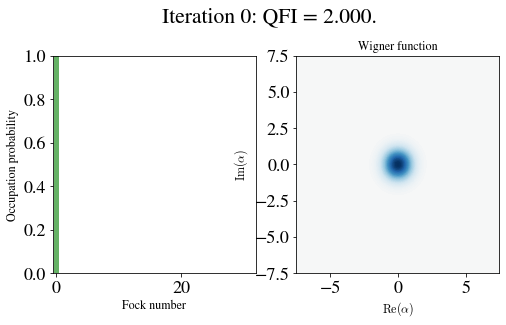

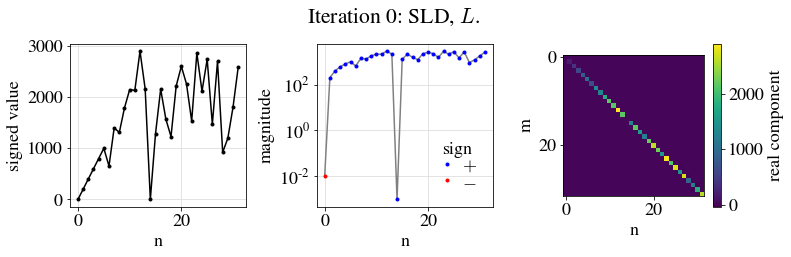

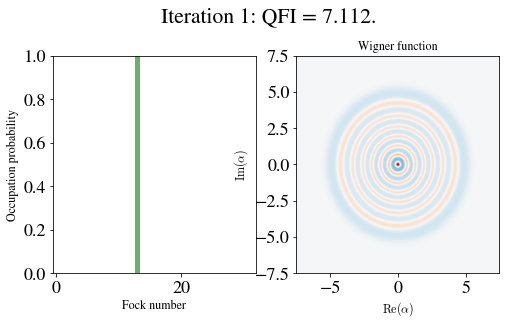

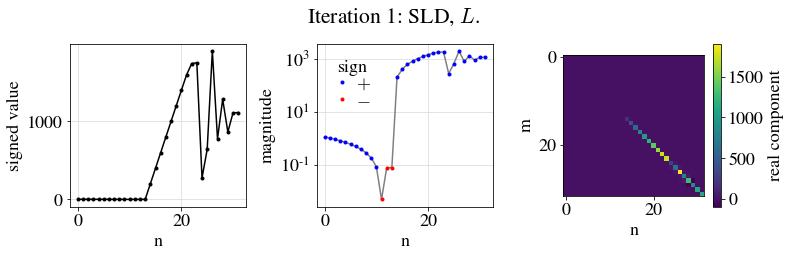

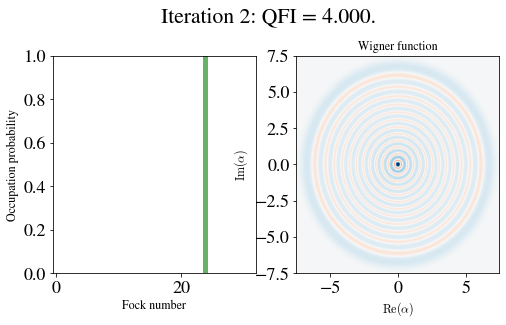

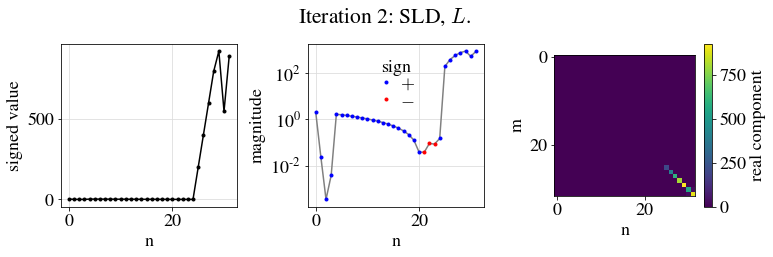

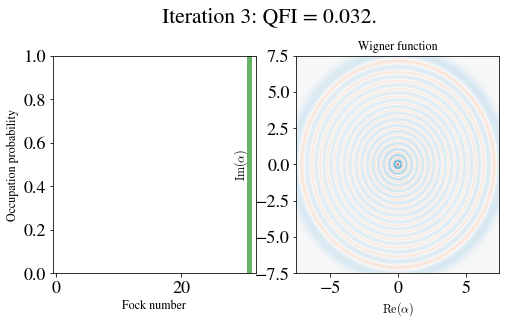

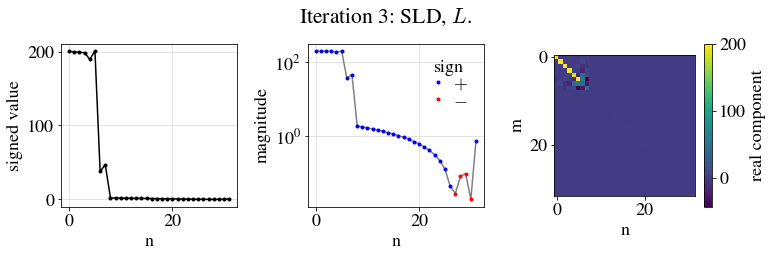

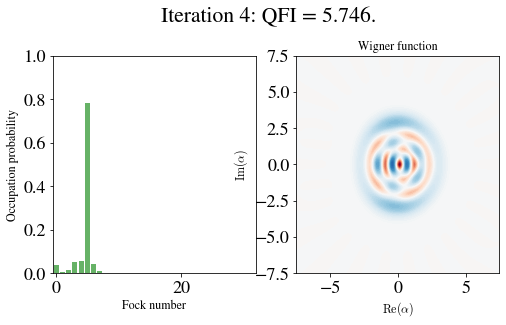

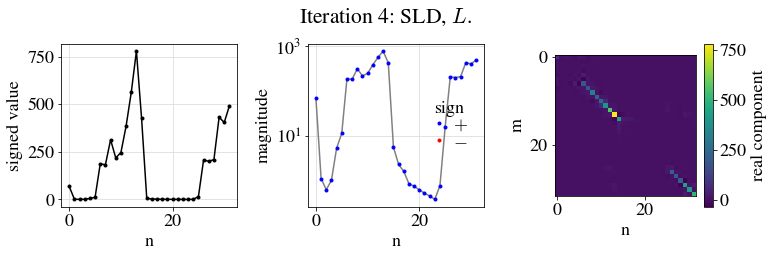

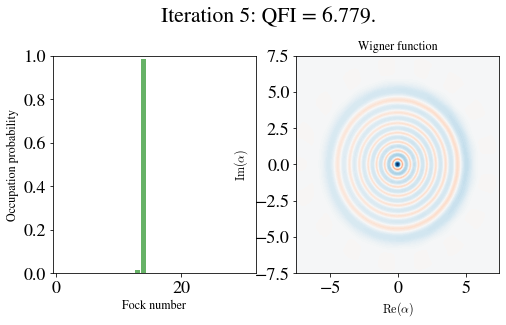

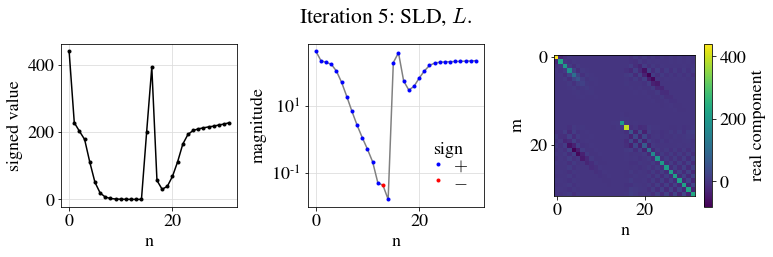

In [16]:
data = var_algorithm(pure_state_ket_parts("vacuum", return_ket=True), num_iter=5)

Stepping through to debug

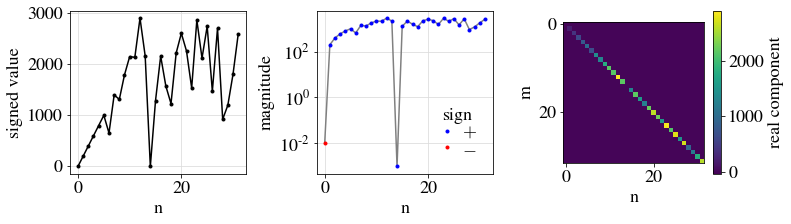

(<Figure size 864x216 with 4 Axes>,
 [<AxesSubplot:xlabel='n', ylabel='m'>,
  <AxesSubplot:xlabel='n', ylabel='magnitude'>,
  <AxesSubplot:xlabel='n', ylabel='signed value'>])

In [9]:
settings = dict(
    σ=0.01,
    δσ=1e-5,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)
construct_total_channel(settings)
ket0 = pure_state_ket_parts("vacuum", return_ket=True)
ρ = ρ_from_ket(ket0)
SLD = sld(ρ)
# print(SLD)
plot_imshow(SLD)
# G_SLD = G(SLD)
# ket1 = next_state_from_SLD(SLD, return_ket=True)

Vacuum iterated many times to hunt for more killers

In [26]:
settings = dict(
    σ=0.01,
    δσ=1e-5,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)
construct_total_channel(settings)

ket0 = pure_state_ket_parts("vacuum", return_ket=True)

data = var_algorithm(ket0, num_iter=20, plot=False)

In [28]:
sorted([[k, v["qfi"]] for k, v in data.items()], key=lambda x: x[1], reverse=True)

[[19, 8.47087395436582],
 [18, 7.61844570906283],
 [1, 7.112302845533158],
 [14, 6.826956702585658],
 [5, 6.778650352069629],
 [10, 6.539584787956456],
 [7, 5.750990793570082],
 [4, 5.745848998054447],
 [15, 5.687916508208651],
 [20, 5.589851400607306],
 [9, 5.354738129758734],
 [11, 5.010095869421756],
 [12, 4.3212980222014234],
 [2, 3.9995313083128505],
 [16, 3.3806138466338798],
 [8, 3.236403791197321],
 [13, 2.782587662179762],
 [17, 2.4870618848117925],
 [0, 1.999799312893527],
 [6, 0.8142127946139955],
 [3, 0.03235377416106411]]

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

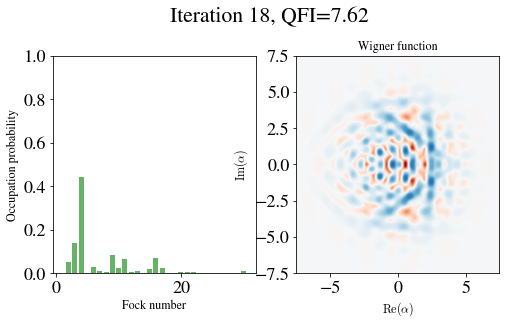

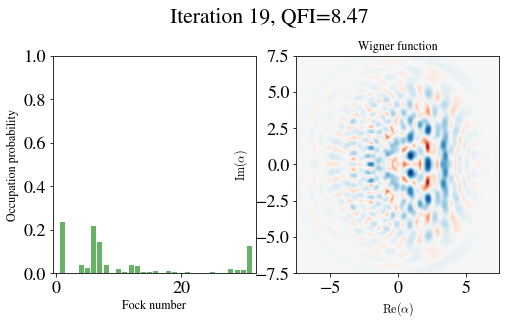

In [44]:
plot_wigner(data[18]["ket"], title=f"Iteration 18, QFI={data[18]['qfi']:.2f}")
plot_wigner(data[19]["ket"], title=f"Iteration 19, QFI={data[19]['qfi']:.2f}")

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

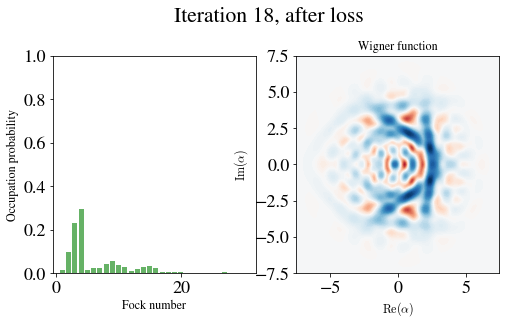

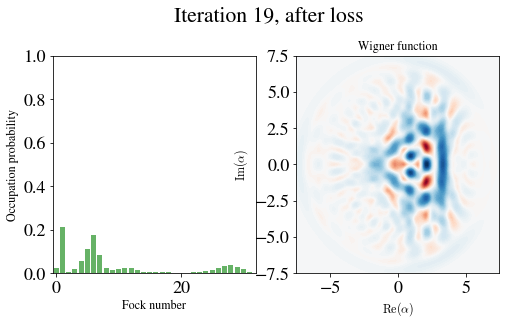

In [42]:
plot_wigner(
    loss_kraus(ρ_from_ket(data[18]["ket"]), settings["η"]),
    title="Iteration 18, after loss",
)
plot_wigner(
    loss_kraus(ρ_from_ket(data[19]["ket"]), settings["η"]),
    title="Iteration 19, after loss",
)

In [ ]:
# Iteration 19
file = "./data/optimisation/variational/killer_itr19.npy"
ket_killer_19 = data[19]["ket"]
np.save(file, ket_killer_19)

Continuing from Killers

In [46]:
# load previously saved killer state
file = "./data/optimisation/variational/killer.npy"
# file = "./data/optimisation/variational/killer_itr19.npy"
ket_killer = np.load(file)
# extend it
ket_killer_ext = np.array([*ket_killer, *np.zeros(Nmax + 1 - len(ket_killer))])

In [47]:
settings = dict(
    σ=0.01,
    δσ=1e-5,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)
construct_total_channel(settings)

data = var_algorithm(ket_killer_ext, num_iter=20, plot=False)

In [59]:
qfis_sorted = sorted(
    [[k, v["qfi"]] for k, v in data.items()], key=lambda x: x[1], reverse=True
)
display(qfis_sorted[:5])

file = "./data/optimisation/variational/killer_itr12.npy"
np.save(file, data[qfis_sorted[0][0]]["ket"])

[[12, 9.494138667168867],
 [0, 9.365377272917843],
 [16, 6.741430301404902],
 [19, 6.156115554605449],
 [18, 6.146015768024073]]

(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

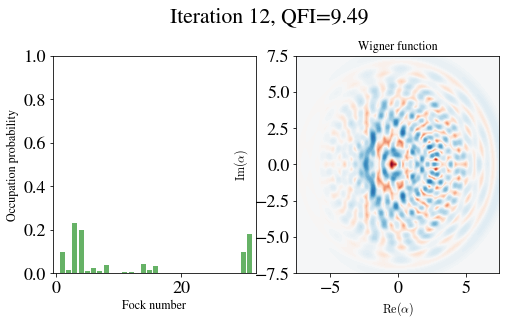

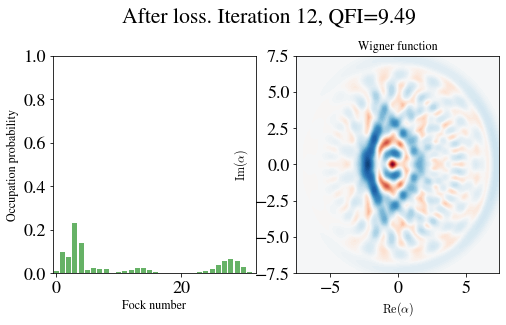

In [52]:
plot_wigner(
    data[qfis_sorted[0][0]]["ket"],
    title=f"Iteration {qfis_sorted[0][0]}, QFI={data[qfis_sorted[0][0]]['qfi']:.2f}",
)
plot_wigner(
    loss_kraus(ρ_from_ket(data[qfis_sorted[0][0]]["ket"]), settings["η"]),
    title=f"After loss. Iteration {qfis_sorted[0][0]}, QFI={data[qfis_sorted[0][0]]['qfi']:.2f}",
)

Killer 2

In [2]:
# load previously saved killer state
# 9.490069901101938, 51
# file = "./data/optimisation/variational/killer.npy"
# 9.937357306431371, 51
file = "./data/optimisation/variational/killer_itr12.npy"

ket_killer = np.load(file)
# extend it
ket_killer_ext = np.array([*ket_killer, *np.zeros(Nmax + 1 - len(ket_killer))])

# Fock beats SMSV
settings = dict(
    σ=0.01,
    δσ=1e-5,
    η=0.1,
    nbar0=1.0,
    encoding_truncation=None,
    which_FI="QFI",
)

# TODO: explain whether this is real for the extended killer (the value has changed by order 0.1 but remains above 7.74 for the best Fock)
FI_total_channel_pure_state(complex_to_real(ket_killer_ext), settings)

9.937357306431371

Iterating from the Killer 2 in larger truncated HS

In [6]:
ρ_loss_killer2 = loss_kraus(ρ_from_ket(ket_killer_ext), settings["η"])

In [25]:
print(
    f"Killer 2. Purity: {purity(ρ_loss_killer2):.3f}. Rank: {rank(ρ_loss_killer2, tol=1e-15)}/{Nmax+1}."
)
print(f"Rank of the identity matrix: {rank(np.identity(Nmax+1))}/{Nmax+1}")

Killer 2. Purity: 0.308+0.000j. Rank: 22/52.
Rank of the identity matrix: 52/52


(<Figure size 576x288 with 2 Axes>,
 array([<AxesSubplot:xlabel='Fock number', ylabel='Occupation probability'>,
        <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

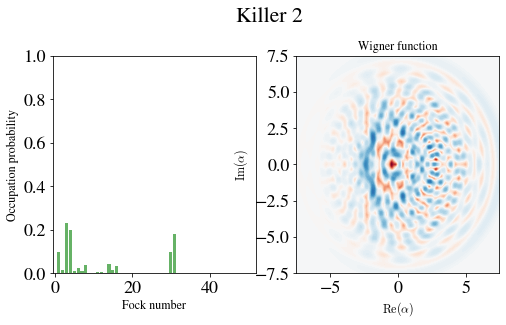

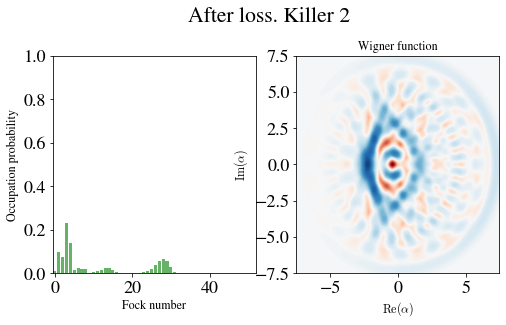

In [5]:
plot_wigner(
    ket_killer_ext,
    title=f"Killer 2",
)
plot_wigner(
    loss_kraus(ρ_from_ket(ket_killer_ext), settings["η"]),
    title=f"After loss. Killer 2",
)

TODO: show that total dual map is consistent

Hybrid: Kraus for loss dual map, LSO for encoding channel